# IDPsych Figures

### Import packages needed

In [1]:
from pymatreader import read_mat
import statistics as stat
import numpy as np
import os
import pprint
from scipy.stats import sem
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

### Subject IDs (imported in lists of strings)
1. sjID_2: sessions with 100ms dot life, 2.5/deg$^2$ dot density
2. sjID_4: sessions with 33ms dot life, 5/deg$^2$ dot density
3. sjID_6: control sessions, using 50% - dec thresholds as inc baselines (inc sessions only)

In [2]:
sjID_2 = ['201', '203', '204', '205', '206']
sjID_4 = ['403', '404', '405', '406', '408']
sjID_6 = ['603', '608']

### Create master dictionaries from data files

In [3]:
customDir = '/Users/kyle/Desktop/UChicago/Maunsell Lab/IDPsych'    
os.chdir(customDir)


def allSubjectDict(sjID):
    '''
    Creates a master dictionary containing all subjects' data
    (calls loadMatFilePyMat to load data files from individual subject)
    :param sjID: specifies which subjects are used for data analysis 
    '''
    allSubject = {}
    for sj in sjID:
        allSubject[sj] = loadMatFilePyMat(sj)
    return allSubject
    

def loadMatFilePyMat(sj, elim = 10, method = 0, last = 10, lastRev = 6):
    '''
    Loads the given matfile and assigns variables to access trial data.
    Returns a dictionary containing:
        1. Task settings
        2. Behavioral settings
        3. Dot settings
        4. Trials data 
    :param sj: specifies which subject's data files are loaded
    :param elim: specifies how many certified trials are eliminated at the 
                 beginning when calculating the hit rate (0 by default)
    :param method: use which method to calculate threshold (0, 1, or 2)
    :param last: specifies how many trials are used to average in method 1
    :param lastRev: specifies how many reversals are used to average in method 2
    '''
    
    os.chdir(os.getcwd() + '/' + sj)
    
    fileList = [name for name in os.listdir() if (name.endswith('.mat') and ('Info' not in name))]
    fileList.sort()
    # Get the unique dates
    fileListDate = list(set([fileList[d][:10] for d in range(len(fileList))]))
    fileListDate.sort()
    
    sjData = {'fileName': fileList,
              'nTrials': [],
              'taskMode': [],
              'stairType': [],
              'frameRateHz': [],
              'baseCohPC': [],
              'behavSettings': [],
              'dotSettings': [],
              'trials': [],
              'rightBiasPC': [],
              'thresholdPC': [],
              'hitRatePC': [],
              'dayOfExp': []}
    
    for fi in fileList:
        allTrials = read_mat(fi)
        allTrialsData = allTrials['trials']
        fileInfo = allTrials['file']
        
        nTrials = len(allTrialsData['trial'])
        sjData['nTrials'].append(nTrials)
        
        # Add task mode: 0 for Dec and 1 for Inc
        sjData['taskMode'].append(allTrialsData['trial'][0]['taskMode'])
        
        # Add staircase type: 0 for joint staircase
        sjData['stairType'].append(allTrialsData['trial'][0]['stairType'])
        sjData['frameRateHz'].append(fileInfo['frameRateHz']['data'])
        baseline = allTrialsData['trial'][0]['baseCohPC']
        sjData['baseCohPC'].append(allTrialsData['trial'][0]['baseCohPC'])
        
        # Add behavioral settings
        sjData['behavSettings'].append({'baseDurMS': allTrialsData['trial'][0]['baseDurMS'],
                                        'stepDurMS': allTrialsData['trial'][0]['stepDurMS'],
                                        'revBeforeChange': 6,
                                        'maxStepPC': abs(allTrialsData['trial'][0]['threshStepsPC']),
                                        'minStepPC': abs(allTrialsData['trial'][-1]['threshStepsPC']),
                                        'stepChangeFactor': 0.5})
        # Add random dot settings
        dots = allTrialsData['randomDots'][0]
        sjData['dotSettings'].append({'azimuthDeg': dots['azimuthDeg'],
                                      'elevationDeg': dots['elevationDeg'],
                                      'radiusDeg': dots['radiusDeg'],
                                      'densityDPD': dots['density'],
                                      'diameterDeg': dots['dotDiameterDeg'],
                                      'speedDPS': dots['speedDPS'],
                                      'lifeFrames': dots['lifeFrames']})
        
        # Add trial codes - 
        # :trialCertify: 0 if the trial is qualified
        # :eotCode: 0 for hits and 1 for misses
        # :stepDir: should stay the same if the staircase is unidirectional, 0 for Dec and 1 for Inc
        # :changeLoc: 0 for left and 1 for right
        sjData['trials'].append({'trialCertify': allTrialsData['trialCertify'],
                                 'eotCode': allTrialsData['eotCode'],
                                 'stepDir': [allTrialsData['trial'][tr]['stepDir'] for tr in range(nTrials)],
                                 'changeLoc': [allTrialsData['trial'][tr]['changeLoc'] for tr in range(nTrials)],
                                 'stepSizePC': [abs(allTrialsData['trial'][tr]['threshStepsPC']) for tr in range(nTrials)],
                                 'trialCohPC': [allTrialsData['trial'][tr]['stepCohPC'] for tr in range(nTrials)]})
       
        # A trial is "certified" only when trialCertify = 0 and eotCode = 0 or 1
        se = fileList.index(fi)
        cert = np.array(sjData['trials'][se]['trialCertify'])
        eot = np.array(sjData['trials'][se]['eotCode'])
        testCertify = np.logical_and(cert == 0, np.logical_or(eot == 1, eot == 0))
        # sjData['trials'][se]['testCertify'] = testCertify
        
        # Add right bias: use only the certified trials
        # right bias = right responses - right changes
        loc = sjData['trials'][se]['changeLoc']
        locFiltered = [loc[tr] for tr in range(nTrials) if testCertify[tr]]
        eotFiltered = [eot[tr] for tr in range(nTrials) if testCertify[tr]]
        rightChanges = sum(locFiltered)
        rightResponses = len([1 for tr in range(len(locFiltered)) if locFiltered[tr] + eotFiltered[tr] == 1])
        sjData['rightBiasPC'].append((rightResponses - rightChanges) / len(locFiltered) * 100)
        
        # Add threshold: by default, use the coherence of the last trial as threshold measurement
        coh = sjData['trials'][se]['trialCohPC']
        cohFiltered = [coh[tr] for tr in range(nTrials) if testCertify[tr]]
        sjData['thresholdPC'].append(threshold(cohFiltered, eotFiltered, baseline, method, last, lastRev))
        
        
        # Add hit rate: use only the certified trials, by default, take all certified trials
        sjData['hitRatePC'].append(hitRate(eotFiltered, elim))
        
        # Add the day of experiment session, separately labeled for Inc/Dec sessions
        sjData['dayOfExp'].append(fileListDate.index(fi[:10]) // 2 + 1)
        
    os.chdir(os.getcwd()[:-3])
    return sjData


def hitRate(eotFiltered, elim = 0):
    '''
    Calculates the hit rate (percentage) for a given measurement. By default,
    it takes all 100 certified trials. If "elim" is not 0, it will
    eliminate the first several trials as given
    :eotFiltered: eot codes filtered using trial certification
    :param elim: specifies how many trials from the beginning are removed
    '''
    hitRatePC = 100 - sum(eotFiltered[elim:]) / len(eotFiltered[elim:]) * 100
    return hitRatePC


def threshold(cohFiltered, eotFiltered, baseline, method = 0, last = 10, lastRev = 6):
    '''
    Calculates the measured threshold from each session using different methods:
        0 (default): take the last trial from the measurement
        1: average the last few trials (10 by default) as the threshold
        2: average the lasf few reversal values (6 by default) as the threshold
    :param cohFiltered: filtered coherence data on each trial
    :param eotFiltered: filtered eot codes on each trial
    :param method: which method to use (0, 1, or 2)
    :param last: specifies how many trials are used to average in method 1
    :param lastRev: specifies how many reversals are used to average in method 2
    '''
    if method == 0:
        return abs(baseline - cohFiltered[-1])
    else:
        nTrials = len(cohFiltered)
        if method == 1:
            return abs(baseline - stat.mean(cohFiltered[-last:]))
        if method == 2:
            currRev = 0
            revList = []
            tr = len(cohFiltered) - 1       # starting from the last trial
            while currRev < lastRev:
                while eotFiltered[tr - 1] == eotFiltered[tr]:
                    tr -= 1
                revList.append(cohFiltered[tr])
                currRev += 1
                tr -=1
            return abs(baseline - stat.mean(revList))

allData_2 = allSubjectDict(sjID_2)
allData_4 = allSubjectDict(sjID_4)
allData_6 = allSubjectDict(sjID_6)

### Check each subject's data

In [4]:
def checkSubjectData(data, sj):
    """
    Returns a dataframe containing the given subject's threshold mean and sem
    for both increment and decrement.
    :param data: the data dictionary
    :param sj: subject number (input as a string)
    """
    taskMode = data[sj]['taskMode']
    thresholdAll = data[sj]['thresholdPC']
    thresholdInc = np.array([thresholdAll[se] for se in range(len(taskMode)) if taskMode[se] == 1])
    thresholdDec = np.array([thresholdAll[se] for se in range(len(taskMode)) if taskMode[se] == 0])
    sjStats = {'Inc': [np.mean(thresholdInc), sem(thresholdInc)],
               'Dec': [np.mean(thresholdDec), sem(thresholdDec)]}
    sjStatsDf = pd.DataFrame(sjStats, index = ['mean', 'sem'])
    return sjStatsDf

checkSubjectData(allData_4, '408')

,Inc,Dec
mean,18.844653,36.389525
sem,1.435447,2.525256


### Change working directory to the output folder

In [5]:
os.chdir('/Users/kyle/Desktop/UChicago/Maunsell Lab/IDPsych/Figures')

### Make primary figures:
1. Scatter plot (100ms lifetime)
2. Scatter plot (33ms lifetime)
3. Control scatter plot (subjects 603 and 608, using 50% - average decrement threshold as the increment baseline)

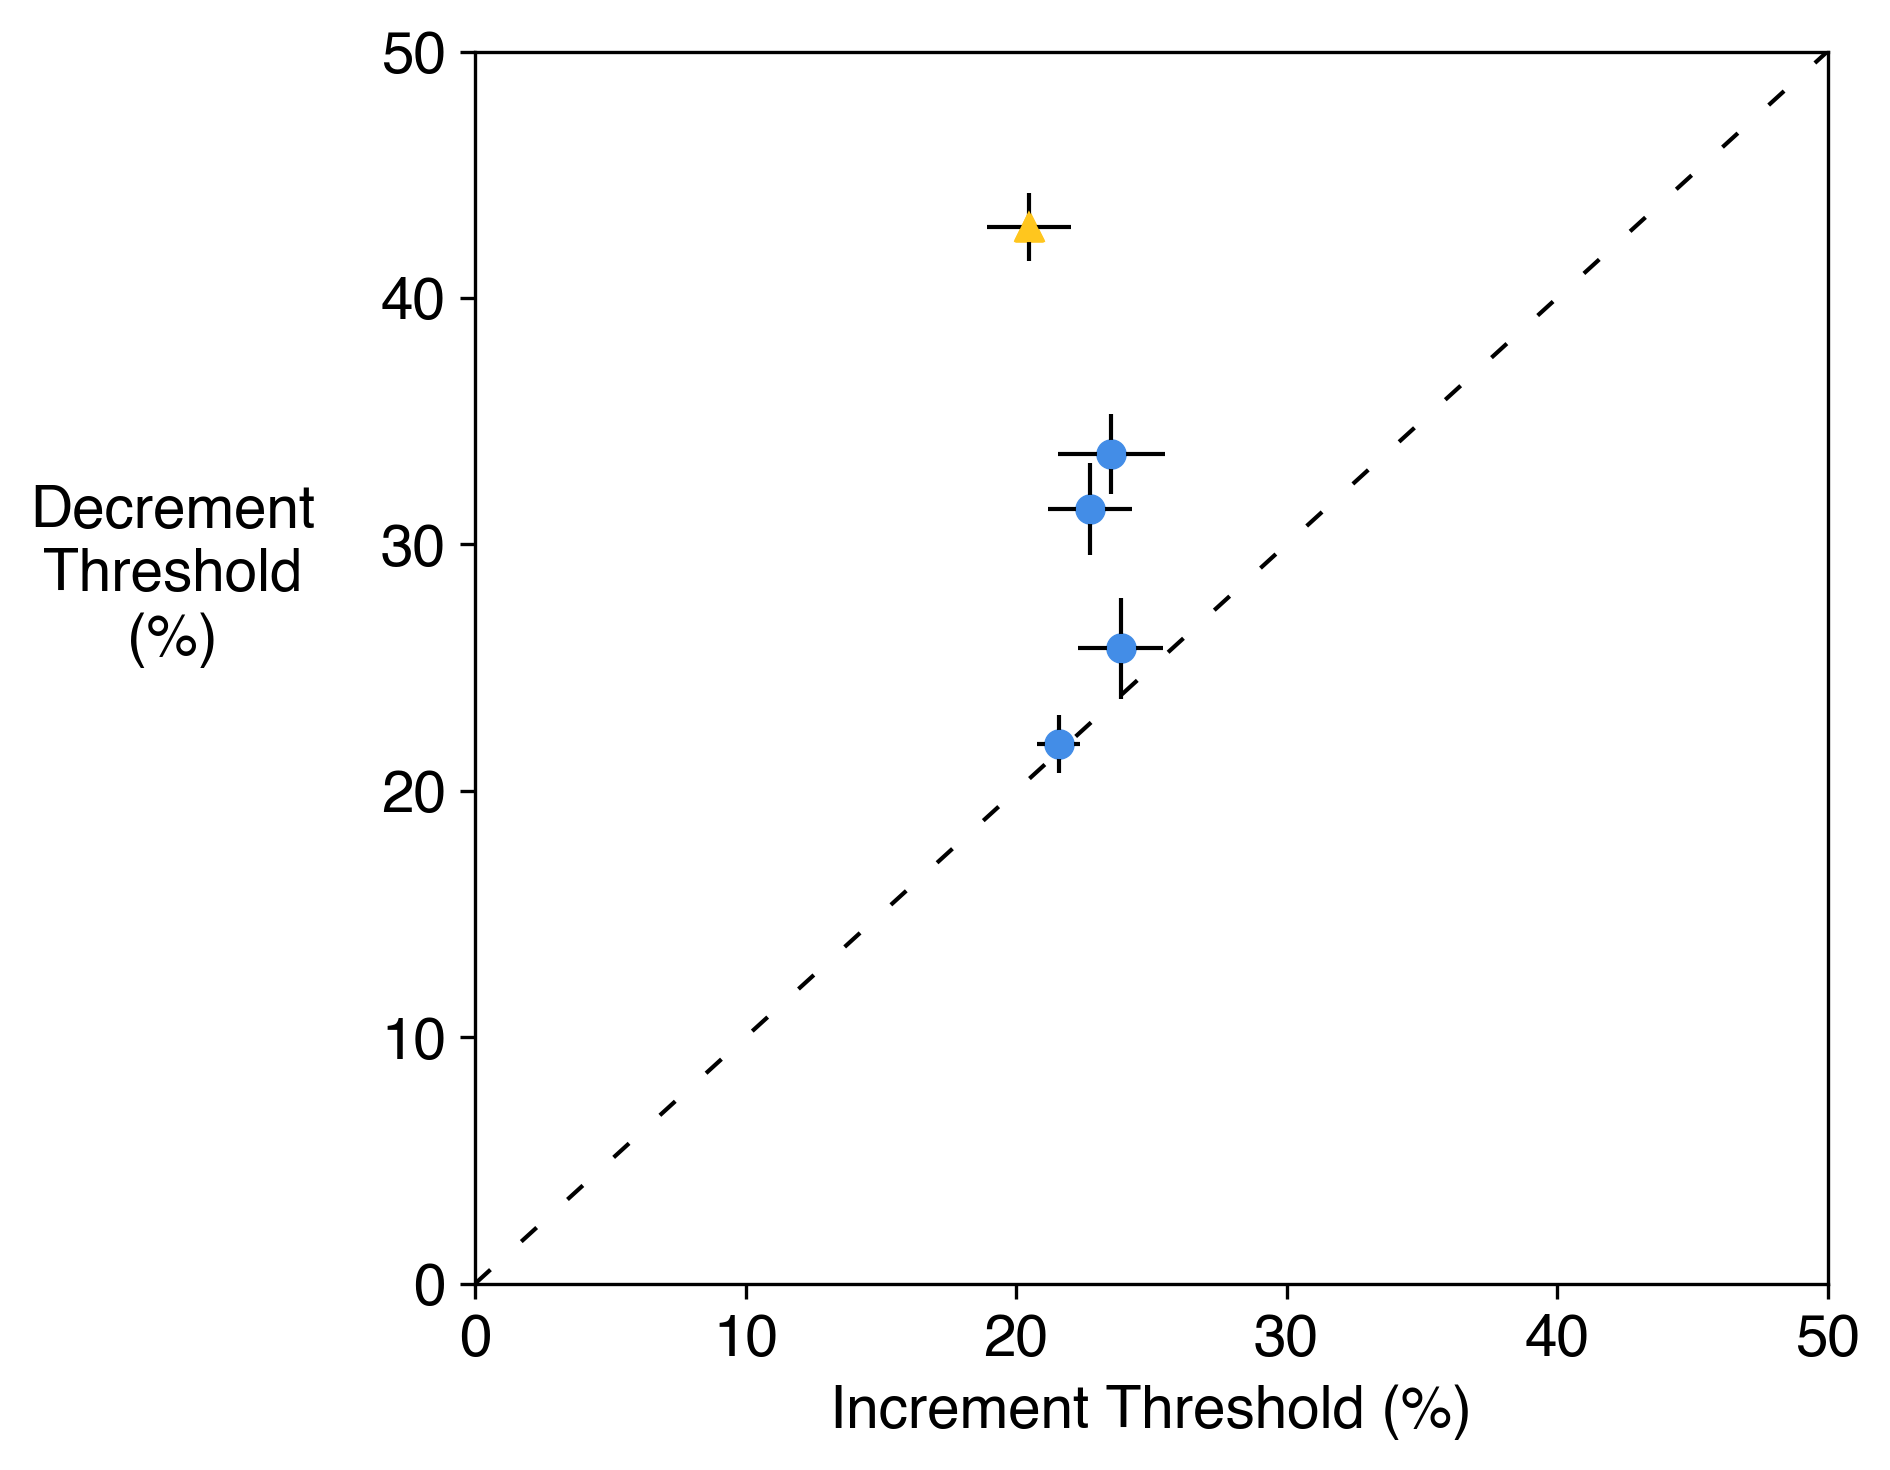

In [6]:
# Scatter plot using the 100ms lifetime data
IDscat2 = plt.figure(figsize=(6.4,5), dpi = 300)
 
for sj in ['201']:
    taskMode = allData_2[sj]['taskMode']
    thresholdPC = allData_2[sj]['thresholdPC']
    Inc = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 1])
    Dec = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 0])    
    plt.errorbar(x = np.mean(Inc), y = np.mean(Dec), xerr = sem(Inc), fmt = '^', color = '#ffc61e',
                 yerr = sem(Dec), ecolor = 'k', linewidth = 1)
    plt.scatter(np.mean(Inc), np.mean(Dec), marker = '^', c = '#ffc61e', s = 40)

for sj in sjID_2[1:]:
    taskMode = allData_2[sj]['taskMode']
    thresholdPC = allData_2[sj]['thresholdPC']
    Inc = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 1])
    Dec = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 0])
    plt.errorbar(x = np.mean(Inc), y = np.mean(Dec), xerr = sem(Inc), fmt = 'o', color = '#438de7',
                 yerr = sem(Dec), ecolor = 'k', linewidth = 1)
    plt.scatter(np.mean(Inc), np.mean(Dec), c = '#438de7' , s = 40)

plt.xlim([0, 50])
plt.ylim([0, 50])
plt.plot([0, 50], [0, 50], 'k--', linewidth = 1, dashes = (5,10))
plt.xticks(fontfamily = 'Helvetica', fontsize = 14)
plt.yticks(fontfamily = 'Helvetica', fontsize = 14)
plt.xlabel('Increment Threshold (%)', fontsize = 14, fontfamily = 'Helvetica')
plt.ylabel('Decrement\nThreshold\n(%)', fontsize = 14, rotation = 0, fontfamily = 'Helvetica', labelpad = 50)
IDscat2.set_tight_layout(True)
plt.show()
#IDscat2.savefig('IDPsych_threshold_scatter_100ms_tightLayout.pdf')

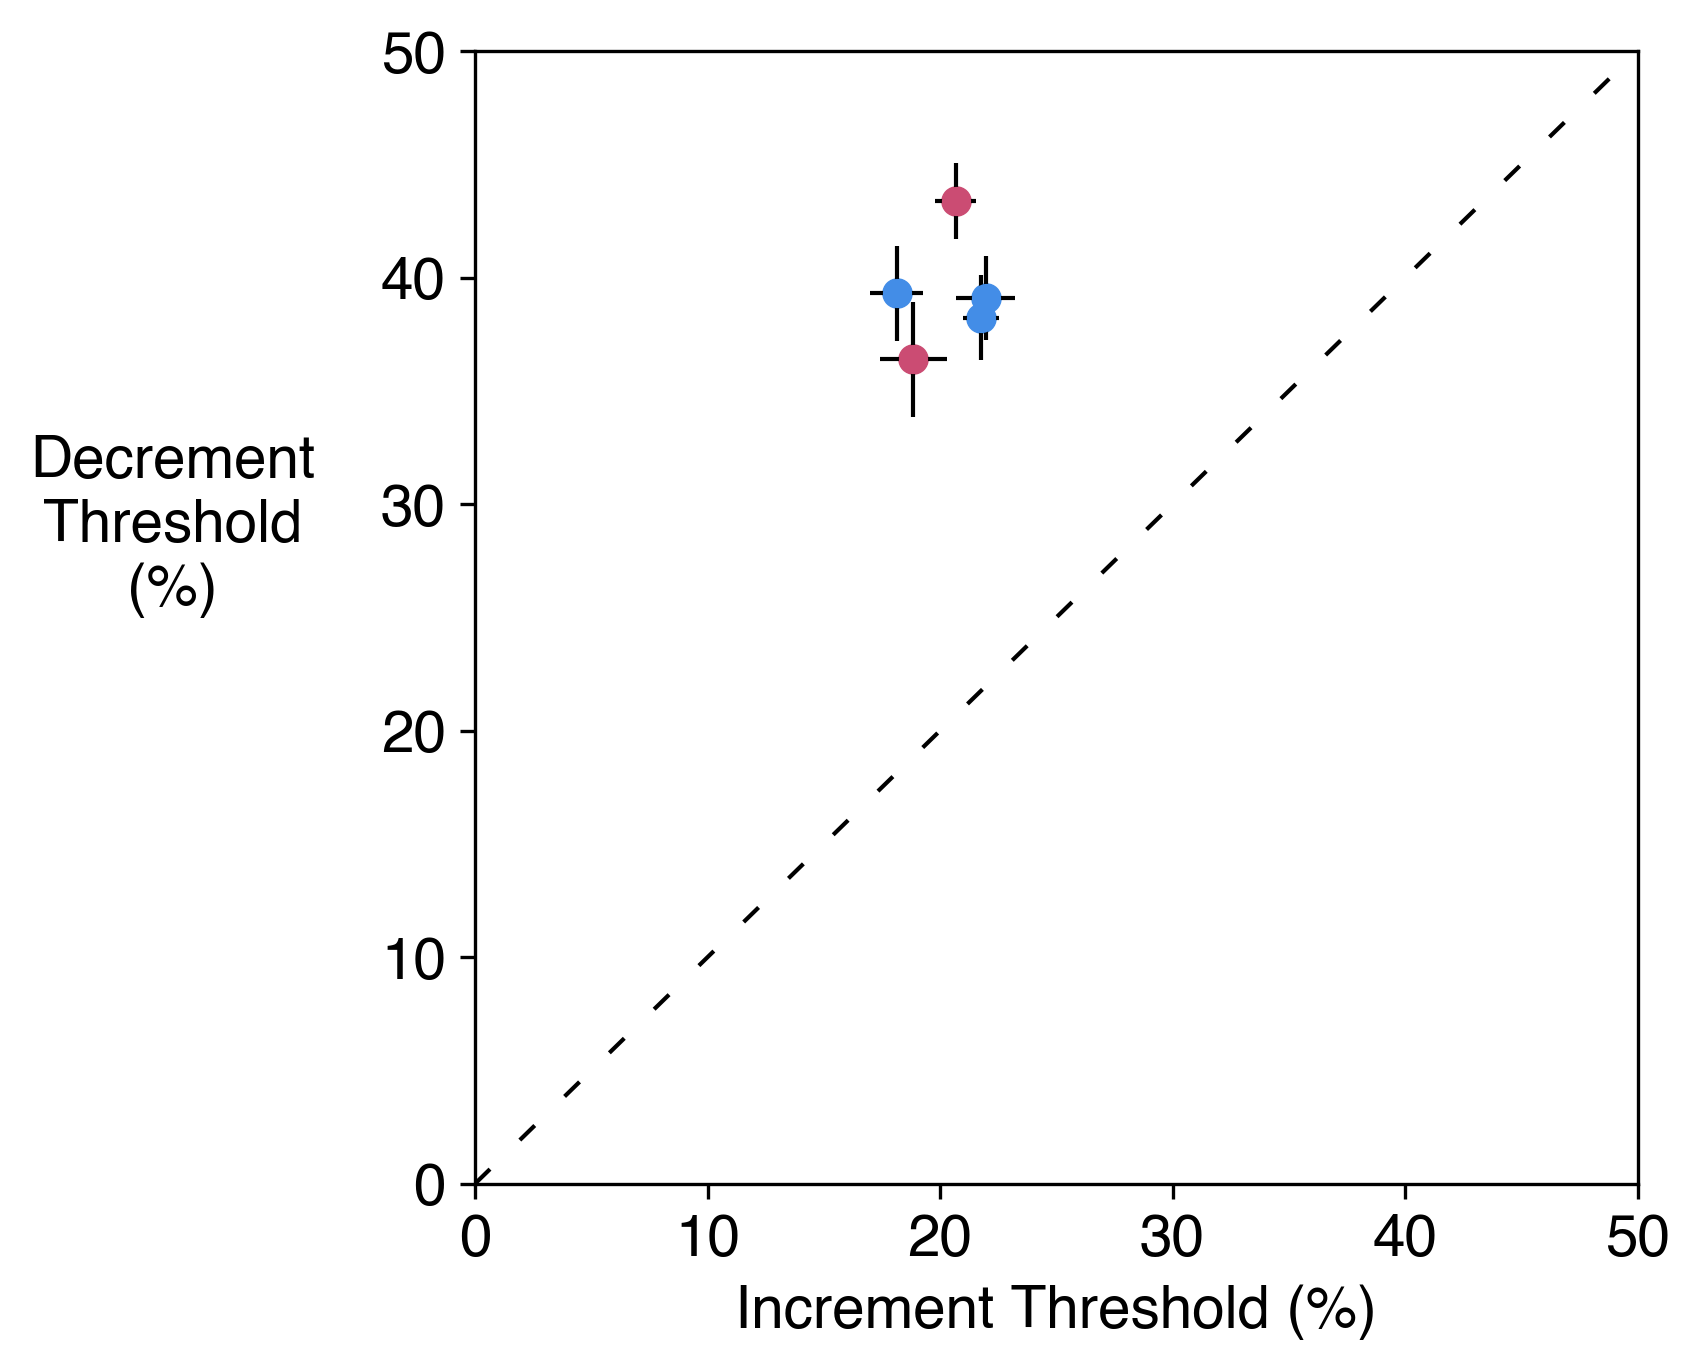

In [7]:
# Scatter plot using the 33ms lifetime data
IDscat4 = plt.figure(figsize=(5,5), dpi = 300)

for sj in ['404', '405', '406']:
    taskMode = allData_4[sj]['taskMode']
    thresholdPC = allData_4[sj]['thresholdPC']
    Inc = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 1])
    Dec = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 0])    
    plt.errorbar(x = np.mean(Inc), y = np.mean(Dec), xerr = sem(Inc), fmt = 'o', color = '#438de7',
                 yerr = sem(Dec), ecolor = 'k', linewidth = 1)
    plt.scatter(np.mean(Inc), np.mean(Dec), c = '#438de7' , s = 40)

for sj in ['403', '408']:
    taskMode = allData_4[sj]['taskMode']
    thresholdPC = allData_4[sj]['thresholdPC']
    Inc = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 1])
    Dec = np.array([thresholdPC[se] for se in range(len(thresholdPC)) if taskMode[se] == 0])
    plt.errorbar(x = np.mean(Inc), y = np.mean(Dec), xerr = sem(Inc), fmt = 'o', color = '#cb4c73',
                 yerr = sem(Dec), ecolor = 'k', linewidth = 1)
    plt.scatter(np.mean(Inc), np.mean(Dec), c = '#cb4c73' , s = 40)

plt.xlim([0, 50])
plt.ylim([0, 50])
plt.plot([0, 50], [0, 50], 'k--', linewidth = 1, dashes = (5,10))
plt.xticks(fontfamily = 'Helvetica', fontsize = 14)
plt.yticks(fontfamily = 'Helvetica', fontsize = 14)
plt.xlabel('Increment Threshold (%)', fontsize = 14, fontfamily = 'Helvetica')
plt.ylabel('Decrement\nThreshold\n(%)', fontsize = 14, rotation = 0, fontfamily = 'Helvetica', labelpad = 50)
#IDscat4.set_tight_layout(True)
plt.show()
#IDscat4.savefig('IDPsych_threshold_scatter_33ms.pdf')

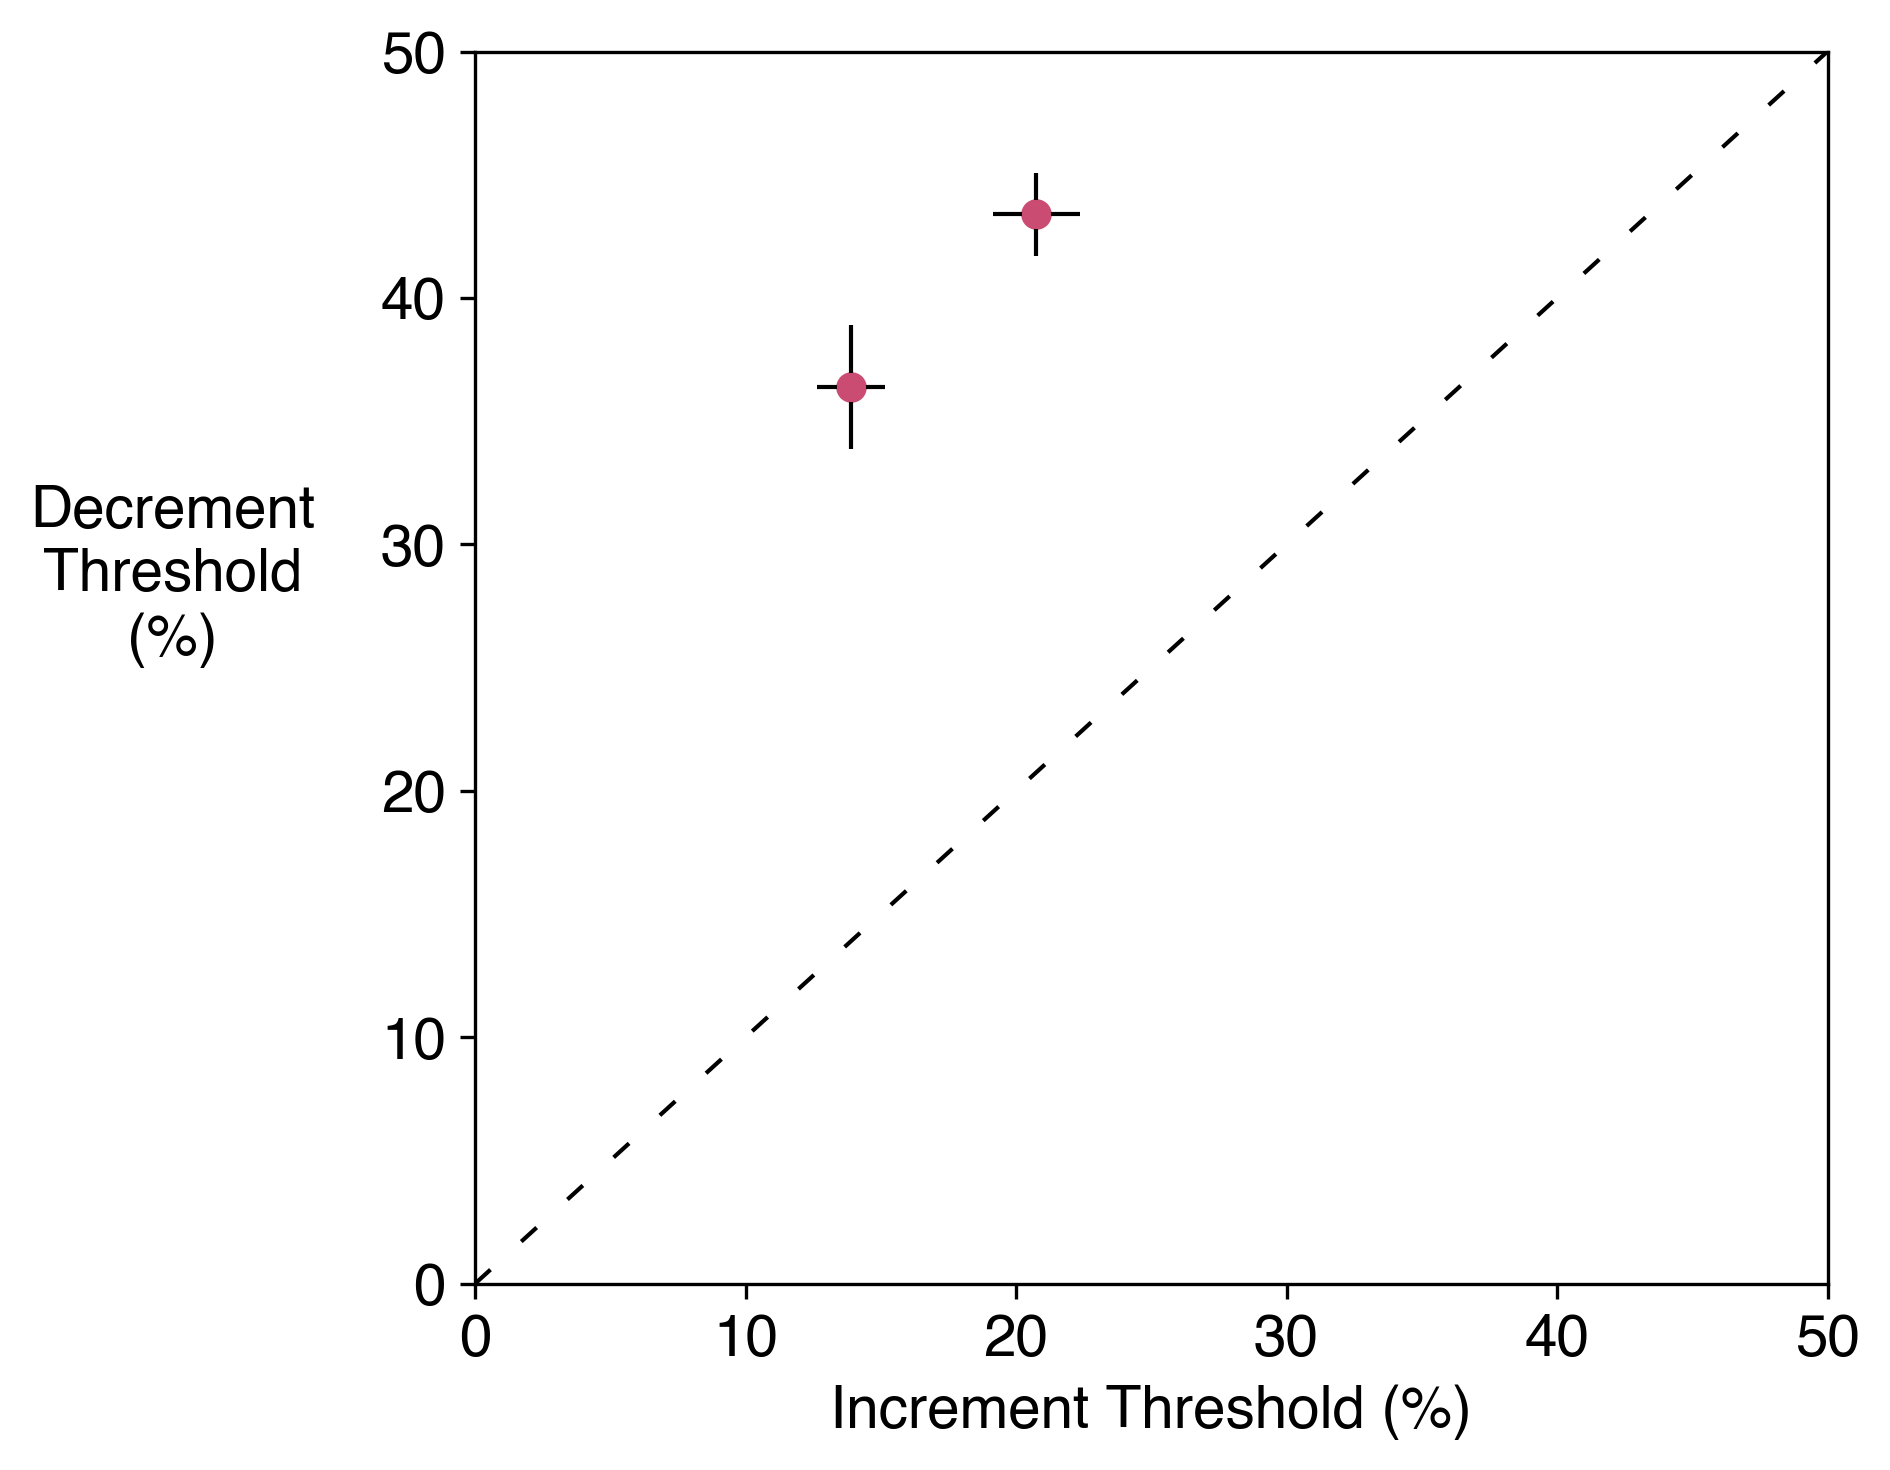

In [8]:
# Control scatter plot
IDscatControl = plt.figure(figsize=(6.4,5), dpi = 300)
 
Dec_403 = np.array([allData_4['403']['thresholdPC'][se] for se in range(30) if allData_4['403']['taskMode'][se] == 0])
Dec_408 = np.array([allData_4['408']['thresholdPC'][se] for se in range(30) if allData_4['408']['taskMode'][se] == 0])

Inc_603 = np.array(allData_6['603']['thresholdPC'])
Inc_608 = np.array(allData_6['608']['thresholdPC'])

plt.scatter(np.mean(Inc_603), np.mean(Dec_403), c = '#cb4c73' , s = 40)
plt.errorbar(x = np.mean(Inc_603), y = np.mean(Dec_403), xerr = sem(Inc_603), yerr = sem(Dec_403),
             fmt = 'o', color = '#cb4c73', ecolor = 'k', linewidth = 1)

plt.scatter(np.mean(Inc_608), np.mean(Dec_408), c = '#cb4c73' , s = 40)
plt.errorbar(x = np.mean(Inc_608), y = np.mean(Dec_408), xerr = sem(Inc_608), yerr = sem(Dec_408),
             fmt = 'o', color = '#cb4c73', ecolor = 'k', linewidth = 1)

plt.xlim([0, 50])
plt.ylim([0, 50])
plt.plot([0, 50], [0, 50], 'k--', linewidth = 1, dashes = (5,10))
plt.xticks(fontfamily = 'Helvetica', fontsize = 14)
plt.yticks(fontfamily = 'Helvetica', fontsize = 14)
plt.xlabel('Increment Threshold (%)', fontsize = 14, fontfamily = 'Helvetica')
plt.ylabel('Decrement\nThreshold\n(%)', fontsize = 14, rotation = 0, fontfamily = 'Helvetica', labelpad = 50)

IDscatControl.set_tight_layout(True)
plt.show()
#IDscatControl.savefig('IDPsych_threshold_scatter_control_tightLayout.pdf')

### Learning effect

Test whether the participants were getting better throughout the sessions, and if we cut off too early to draw the final conclusion of threshold ratios.

In [9]:
def fitExp(x,a,b,c):
    """
    Returns the exponential function used in fitting
    """
    return a * np.exp(b * x) + c

xFit = np.linspace(1,15,15)

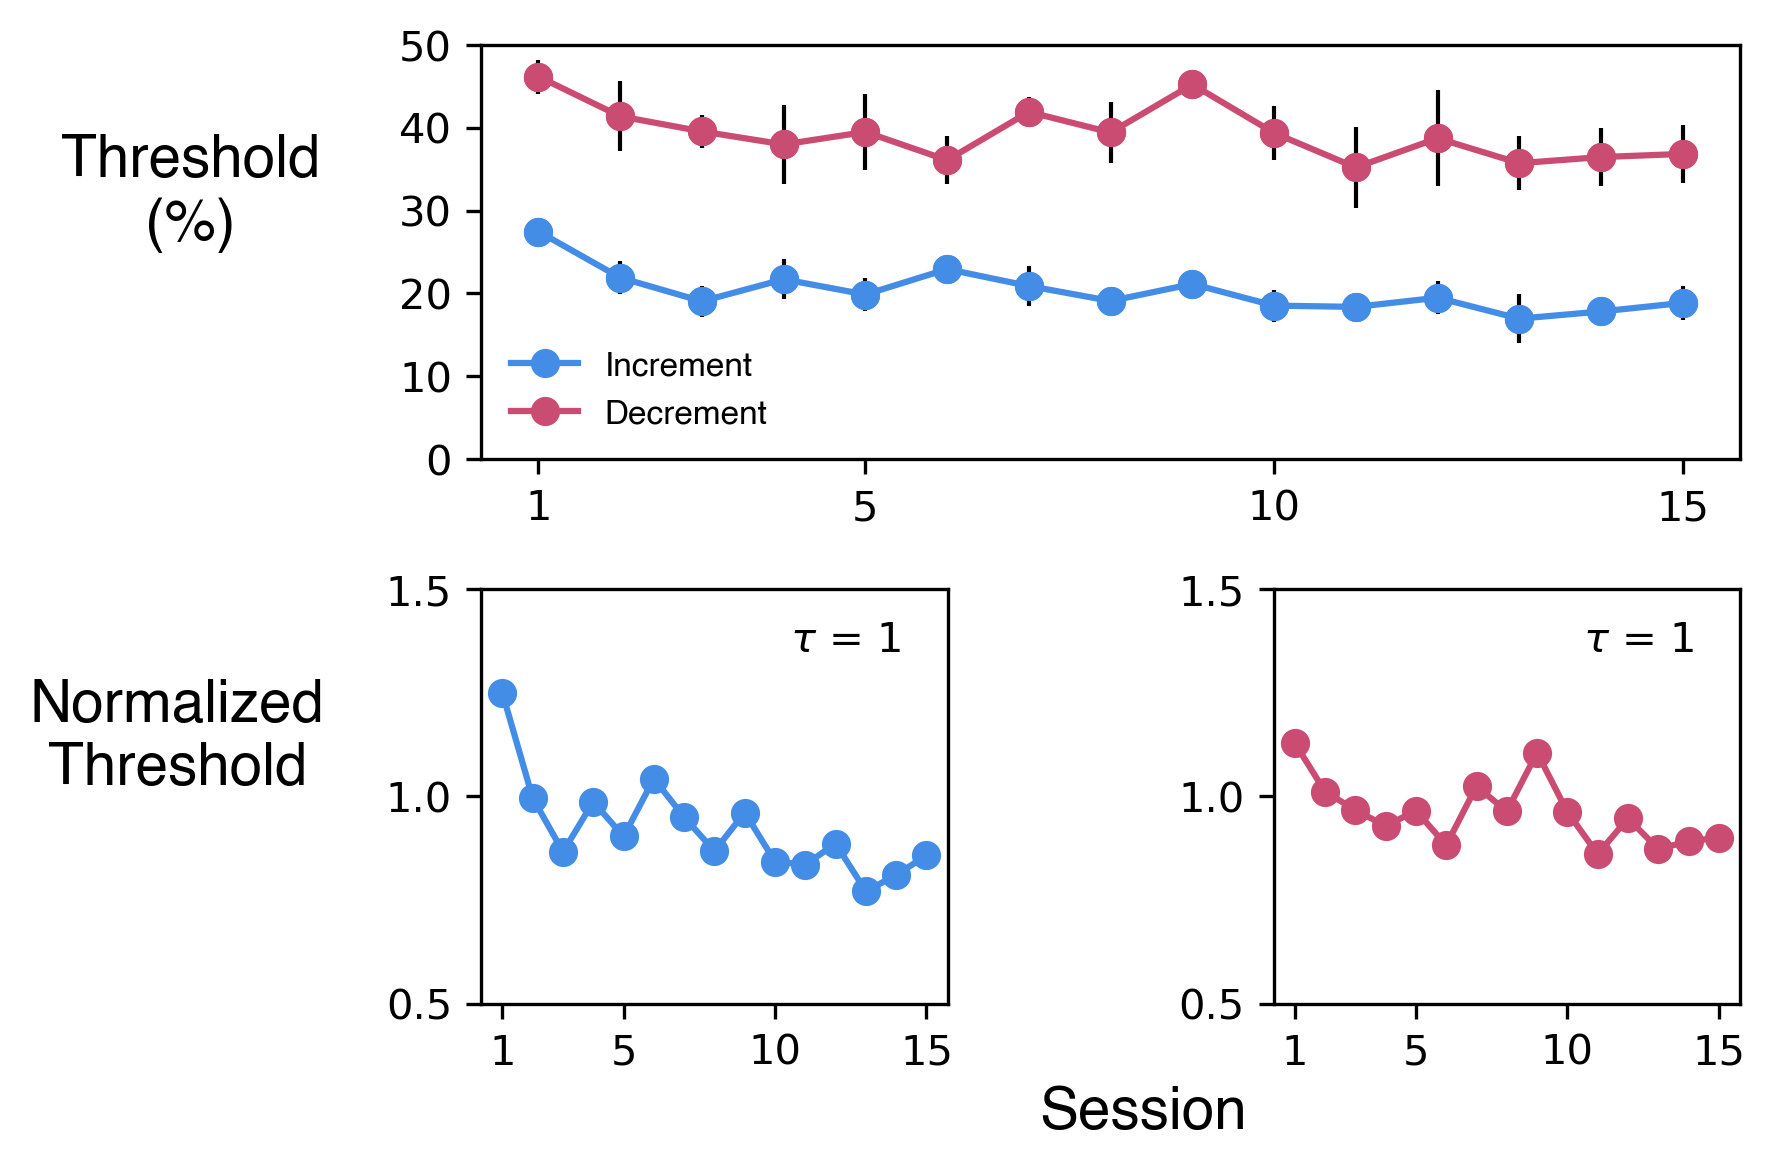

In [10]:
# Fit the increment and decrement sessions using exponential curves
# The Inc thresholds are normalized using the average threshold for the first five measurements, same for Dec
allInc = []
allDec = []
for sj in sjID_4:
    taskMode = allData_4[sj]['taskMode']
    allInc.append([allData_4[sj]['thresholdPC'][se] for se in range(len(taskMode)) if taskMode[se] == 1])
    allDec.append([allData_4[sj]['thresholdPC'][se] for se in range(len(taskMode)) if taskMode[se] == 0])
    
aveInc = np.mean(np.array(allInc), axis = 0)
aveDec = np.mean(np.array(allDec), axis = 0)
normInc = aveInc / np.mean(aveInc[:5])
normDec = aveDec / np.mean(aveDec[:5])

fitInc = curve_fit(fitExp, xFit, normInc, bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf]), maxfev = 1000)
fitDec = curve_fit(fitExp, xFit, normDec, bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf]), maxfev = 1000)

psychLearn = plt.figure(dpi = 300)
gs = psychLearn.add_gridspec(2,2)
ax0 = psychLearn.add_subplot(gs[0,:])

ax0.plot(xFit, aveInc, '-o', color = '#438de7')
ax0.plot(xFit, aveDec, '-o', color = '#cb4c73')
ax0.errorbar(x = xFit, y = aveInc, yerr = sem(allInc), fmt = 'o', color = '#438de7',
             ecolor = 'k', linewidth = 1)
ax0.errorbar(x = xFit, y = aveDec, yerr = sem(allDec), fmt = 'o', color = '#cb4c73',
             ecolor = 'k', linewidth = 1)
ax0.set_ylim([0,50])
ax0.set_xticks([1,5,10,15], fontsize = 14, fontfamily = 'Helvetica')
ax0.set_yticks([0,10,20,30,40,50], fontsize = 14, fontfamily = 'Helvetica')

ax0.set_ylabel('Threshold\n(%)', fontsize = 14, rotation = 0, fontfamily = 'Helvetica', labelpad = 50)
lg = plt.legend({'Increment', 'Decrement'}, frameon = False, fontsize = 8)
plt.setp(lg.texts, family = 'Helvetica')


ax1 = psychLearn.add_subplot(gs[1,0])
ax1.plot(xFit, normInc, '-o', color = '#438de7')
ax1.set_ylim([0.5,1.5])
ax1.set_xticks([1,5,10,15], fontsize = 14, fontfamily = 'Helvetica')
ax1.set_yticks([0.5,1,1.5], fontsize = 14, fontfamily = 'Helvetica')
ax1.set_ylabel('Normalized\nThreshold', fontsize = 14, rotation = 0, fontfamily = 'Helvetica', labelpad = 50)
ax1.text(10.5,1.35, r'$\tau$ = ' + str(round(-1/fitInc[0][1])))

ax2 = psychLearn.add_subplot(gs[1,1])
ax2.plot(xFit, normDec, '-o', color = '#cb4c73')
ax2.set_ylim([0.5,1.5])
ax2.set_xticks([1,5,10,15], fontsize = 14, fontfamily = 'Helvetica')
ax2.set_yticks([0.5,1,1.5], fontsize = 14, fontfamily = 'Helvetica')
ax2.text(10.5,1.35, r'$\tau$ = ' + str(round(-1/fitDec[0][1])))

plt.text(-4,0.2,'Session', fontsize = 14, fontfamily = 'Helvetica', horizontalalignment = 'center')
psychLearn.set_tight_layout(True)
#psychLearn.savefig('learning_tightLayout.pdf')

Text(-2.5, 1.3, 'Normalized\nThreshold')

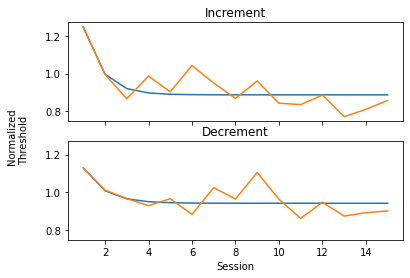

In [11]:
# Visualize the fits

IDfit, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, sharey = True)

ax1.plot(xFit, fitInc[0][0] * np.exp(fitInc[0][1] * xFit) + fitInc[0][2], '-')
ax1.plot(xFit, normInc, '-')


ax1.set_title('Increment')

ax2.plot(xFit, fitDec[0][0] * np.exp(fitDec[0][1] * xFit) + fitDec[0][2], '-')
ax2.plot(xFit, normDec, '-')
ax2.set_xlabel('Session')
ax2.set_title('Decrement')
plt.text(-2.5, 1.3, 'Normalized\nThreshold', va = 'center', rotation = 'vertical')

,403,404,405,406,408,Average
Increment tau,0.7,0.9,19.9,0.7,4.7,0.8
y-intercept,50.1,43.4,24.1,51.4,33.9,45.5
Asymptote,20.1,17.3,16.7,21.4,13.2,19.5
Decrement tau,27.2,0.5,0.6,9.6,11.1,1.0
y-intercept,50.8,69.0,67.7,47.5,50.7,60.3
Asymptote,20.8,39.0,37.7,31.4,20.7,38.5


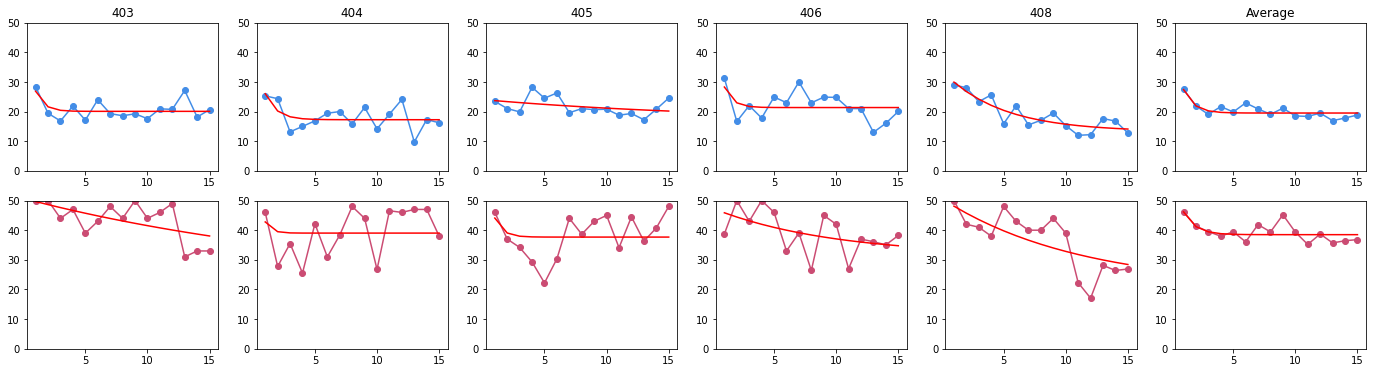

In [12]:
# Fit each subject's unnormalized data

sjFits = {}

sjLearn = plt.figure(figsize = (24,6))
gs = sjLearn.add_gridspec(2,6)

for sj in allData_4:
    taskMode = allData_4[sj]['taskMode']
    Inc = [allData_4[sj]['thresholdPC'][se] for se in range(len(taskMode)) if taskMode[se] == 1]
    Dec = [allData_4[sj]['thresholdPC'][se] for se in range(len(taskMode)) if taskMode[se] == 0]
    sjFitInc = curve_fit(fitExp, xFit, np.array(Inc), 
                         bounds = ([0, -np.inf, 0], [30, -0.002, max(Inc)]), maxfev = 1000)
    sjFitDec = curve_fit(fitExp, xFit, np.array(Dec),
                         bounds = ([0, -np.inf, 0], [30, -0.002, max(Dec)]), maxfev = 1000)
    sjFits[sj] = [round(-1 / sjFitInc[0][1], 1), round(sjFitInc[0][0] + sjFitInc[0][2], 1), round(sjFitInc[0][2], 1), 
                  round(-1 / sjFitDec[0][1], 1), round(sjFitDec[0][0] + sjFitDec[0][2], 1), round(sjFitDec[0][2], 1)]   
    
    ax0 = sjLearn.add_subplot(gs[0,sjID_4.index(sj)]) # Increment
    ax0.plot(xFit, Inc, '-o', color = '#438de7')
    ax0.plot(xFit, sjFitInc[0][0] * np.exp(sjFitInc[0][1] * xFit) + sjFitInc[0][2], '-r')
    ax0.set_ylim([0,50])
    ax0.set_title(sj)
    ax1 = sjLearn.add_subplot(gs[1,sjID_4.index(sj)]) # Decrement
    ax1.plot(xFit, Dec, '-o', color = '#cb4c73') 
    ax1.plot(xFit, sjFitDec[0][0] * np.exp(sjFitDec[0][1] * xFit) + sjFitDec[0][2], '-r')
    ax1.set_ylim([0,50])

aveFitInc = curve_fit(fitExp, xFit, aveInc, bounds = ([0, -np.inf, 0], [30, -0.002, max(aveInc)]), maxfev = 1000)
aveFitDec = curve_fit(fitExp, xFit, aveDec, bounds = ([0, -np.inf, 0], [30, -0.002, max(aveDec)]), maxfev = 1000)
ax0 = sjLearn.add_subplot(gs[0,5]) # Average Increment
ax0.plot(xFit, aveInc, '-o', color = '#438de7')
ax0.plot(xFit, aveFitInc[0][0] * np.exp(aveFitInc[0][1] * xFit) + aveFitInc[0][2], '-r')
ax0.set_ylim([0,50])
ax0.set_title('Average')
ax1 = sjLearn.add_subplot(gs[1,5]) # Average Decrement
ax1.plot(xFit, aveDec, '-o', color = '#cb4c73')
ax1.plot(xFit, aveFitDec[0][0] * np.exp(aveFitDec[0][1] * xFit) + aveFitDec[0][2], '-r')
ax1.set_ylim([0,50])


sjFits['Average'] = [round(-1 / aveFitInc[0][1], 1), round(aveFitInc[0][0] + aveFitInc[0][2], 1),
                     round(aveFitInc[0][2], 1), 
                     round(-1 / aveFitDec[0][1], 1), round(aveFitDec[0][0] + aveFitDec[0][2], 1), 
                     round(aveFitDec[0][2], 1)]

sjFitsDf = pd.DataFrame(sjFits, index = ['Increment tau', 'y-intercept', 'Asymptote',
                                         'Decrement tau', 'y-intercept', 'Asymptote'])
sjFitsDf